## Homework 3

* Generate dataset using `make_blobs` function in the sklearn.datasets class. Generate 2000 samples with 3 features (X) with one label (y).
* Explore and analyse raw data.
* Do preprocessing for classification.
* Split your dataset into train and test test (0.7 for train and 0.3 for test).
* Try Decision Tree and XGBoost Algorithm with different hyperparameters. (Using GridSearchCV is a plus)
* Evaluate your result on both train and test set. Analyse if there is any underfitting or overfitting problem. Make your comments.

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV 
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, classification_report, f1_score, confusion_matrix


## GENERATE DATASET

In [3]:
#Generate dataset
a, b = make_blobs(n_samples=2000, n_features=3, random_state=0)    

In [4]:
x = pd.DataFrame(a, columns=['var1','var2','var3'])
y = pd.DataFrame(b, columns=['label'])
pd.concat([x,y],axis=1).head()

,var1,var2,var3,label
0,0.378197,-0.822654,4.412505,1
1,0.112908,8.072768,9.914998,2
2,1.875986,-2.862337,1.955307,1
3,-1.210594,6.876798,9.223306,2
4,2.095730,3.335208,3.288496,0


In [5]:
pd.concat([x,y],axis=1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   var1    2000 non-null   float64
 1   var2    2000 non-null   float64
 2   var3    2000 non-null   float64
 3   label   2000 non-null   int32  
dtypes: float64(3), int32(1)
memory usage: 54.8 KB


## EDA AND PREPROCESSING

As we can see, we have a dataset with 3 features and a label with 3 clasees. We need to explore:

1. Class balance
2. Missing values
3. Duplicated values
4. Outliers
5. Need for feature scaling (although if I will use trees, I don´t need feature scaling)

Bucketing, feature extraction, label encoding and one-hot encoding are not necessary because of the way I constructed the dataset

In [6]:
# CLASS BALANCE
pd.concat([x,y],axis=1).groupby(['label']).count()

,var1,var2,var3
label,,,
0,667,667,667
1,667,667,667
2,666,666,666


The dataset is balanced

In [7]:
# MISSING VALUES
pd.concat([x,y],axis=1).isnull().sum()

var1     0
var2     0
var3     0
label    0
dtype: int64

There are no missing values

In [8]:
# DUPLICATED VALUES
pd.concat([x,y],axis=1).duplicated(subset=None, keep='first').sum()

0

There are no duplicate values

In [9]:
# OUTLIERS
z = np.abs(stats.zscore(pd.concat([x,y],axis=1)))
outliers = list(set(np.where(z > 3)[0]))
len(outliers)

2

In [10]:
clean = pd.concat([x,y],axis=1).drop(outliers,axis = 0).reset_index(drop = True)
x = clean.drop(['label'], axis=1)
y = clean['label']
print(x.head())
print(y.head())

       var1      var2      var3
0  0.378197 -0.822654  4.412505
1  0.112908  8.072768  9.914998
2  1.875986 -2.862337  1.955307
3 -1.210594  6.876798  9.223306
4  2.095730  3.335208  3.288496
0    1
1    2
2    1
3    2
4    0
Name: label, dtype: int32


Outliers have been cleaned

In [11]:
# FEATURE SCALING
x.describe()

,var1,var2,var3
count,1998.000000,1998.000000,1998.000000
mean,0.245356,3.488528,4.735872
std,1.413559,4.001435,3.406425
min,-3.977186,-5.351844,-1.459501
25%,-0.756575,-0.969717,2.114328
50%,0.387156,4.274920,3.204800
75%,1.244792,7.136971,8.645710
max,4.077801,11.046691,12.079492


There is no need for feature scaling, besides tree algorithms do not require it anyways

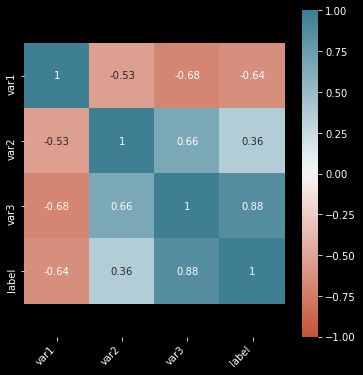

In [12]:
# CORRELATIONS 
corr = clean.corr()

plt.figure(figsize=(6, 6))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)
ax.set_ylim(len(corr)+0.5, -0.5);

It looks as if var1 and var2 have the most explanatory power on the label

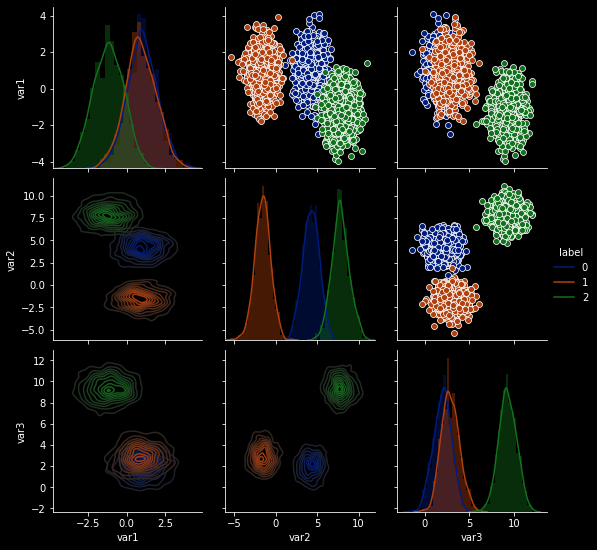

In [13]:
# VISUALIZE DATASET
sns.set_palette('dark')
g = sns.PairGrid(clean, diag_sharey=False, hue="label")
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.distplot)
g.add_legend()

The distribution of var2 shows three modes (albeit two of them too close). Var 1 appears to be similarly distributed among the first two classes. Var3 shows a similar behavior, with a little more separation among classes.

In summary, we have a clean dataset ready for classification.

## CLASSIFICATION

In [14]:
# Split the dataset
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=0,shuffle=True,test_size=0.3)
print("length x_train = ", len(x_train), ", lenght x_test = ", len(x_test))

length x_train =  1398 , lenght x_test =  600


### DECISION TREES

In [15]:
clf = DecisionTreeClassifier(max_depth=4, random_state=0)
clf.fit(x_train,y_train)
print("Accuracy of train:",clf.score(x_train,y_train))
print("Accuracy of test:",clf.score(x_test,y_test))

Accuracy of train: 1.0
Accuracy of test: 0.995


In [16]:
# Metrics
pred = clf.predict(x_test)
print("Precision = {}".format(precision_score(y_test, pred, average='weighted')))
print("Recall = {}".format(recall_score(y_test, pred, average='weighted')))
print("Accuracy = {}".format(accuracy_score(y_test, pred)))
print("F1 Score = {}".format(f1_score(y_test, pred,average='weighted')))

Precision = 0.995001370614035
Recall = 0.995
Accuracy = 0.995
F1 Score = 0.9949967053455293


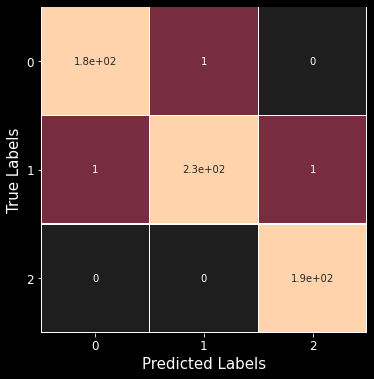

In [17]:
cm = confusion_matrix(y_test, pred)
labels = [0,1,2]

plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm, vmax=3, center=0, linewidths=.5,square=True, annot = True, cbar=False)
ax.xaxis.set_ticklabels(labels, fontsize = 12)
ax.yaxis.set_ticklabels(labels, fontsize = 12, rotation=0)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()

### XGBOOST

In [18]:
dmatrix_train = xgb.DMatrix(data=x_train, label=y_train)
dmatrix_test = xgb.DMatrix(data=x_test, label=y_test)

In [19]:
param = {'max_depth':3, 'eta':1, 'objective':'multi:softprob', 'num_class':3}
num_round = 5
model = xgb.train(param, dmatrix_train, num_round)

In [20]:
preds2 = model.predict(dmatrix_test)
best_preds = np.asarray([np.argmax(line) for line in preds2])

In [21]:
print("Precision = {}".format(precision_score(y_test, best_preds, average='weighted')))
print("Recall = {}".format(recall_score(y_test, best_preds, average='weighted')))
print("Accuracy = {}".format(accuracy_score(y_test, best_preds)))
print("F1 Score = {}".format(f1_score(y_test, pred,average='weighted')))

Precision = 0.995001370614035
Recall = 0.995
Accuracy = 0.995
F1 Score = 0.9949967053455293


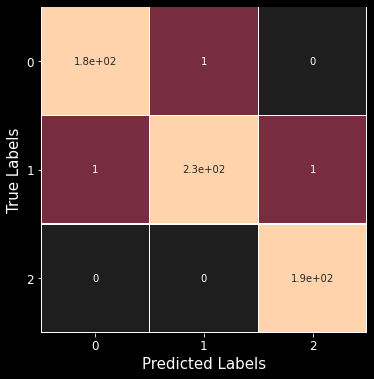

In [22]:
cm2 = confusion_matrix(y_test, best_preds)

plt.figure(figsize=(6, 6))
ax = sns.heatmap(cm2, vmax=3, center=0, linewidths=.5,square=True, annot = True, cbar=False)
ax.xaxis.set_ticklabels(labels, fontsize = 12)
ax.yaxis.set_ticklabels(labels, fontsize = 12, rotation=0)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()

### At this point decision trees and XGBoost are returning the exact same results

## HYPERPARAMETER TUNING

### Decision Tree

In [23]:
tree_params = {'criterion':('gini', 'entropy'),
                'splitter':('best','random'),
                'max_depth':[3,5,7,9],
                'min_samples_split':[2,3,4,5]}

In [24]:
tree_model = DecisionTreeClassifier(random_state=0)
tree_clf = GridSearchCV(tree_model,tree_params)
tree_clf.fit(x_train,y_train)

GridSearchCV(estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': [3, 5, 7, 9],
                         'min_samples_split': [2, 3, 4, 5],
                         'splitter': ('best', 'random')})

In [25]:
preds = tree_clf.predict(x_test)
print("Train Score {:.6f}".format(tree_clf.score(x_train,y_train)))
print("Test Score {:.6f}".format(tree_clf.score(x_test,y_test)))

Train Score 1.000000
Test Score 0.995000


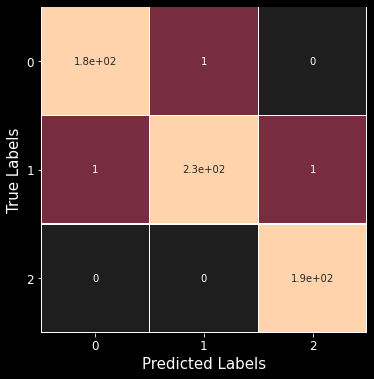

In [26]:
tree_pred = tree_clf.predict(x_test)
tree_cm = confusion_matrix(y_test, tree_pred)

plt.figure(figsize=(6, 6))
ax = sns.heatmap(tree_cm, vmax=3, center=0, linewidths=.5,square=True, annot = True, cbar=False)
ax.xaxis.set_ticklabels(labels, fontsize = 12)
ax.yaxis.set_ticklabels(labels, fontsize = 12, rotation=0)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()

### XGBoost

In [27]:
xgb_params = {'max_depth':[3,5,7,9],
                'min_child_weight':[1,3,5],
                'learning_rate': [0.001,0.01,0.1,1,2],
                'n_estimators': [10,190,200,210,500]}

In [28]:
xgb = XGBClassifier(booster='gbtree', random_state=0)
clf = GridSearchCV(xgb,xgb_params)
clf.fit(x_train,y_train)

GridSearchCV(estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=0,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, validate_paramete

In [29]:
print("Tuned: {}".format(clf.best_params_)) 
print("Mean of the cv scores is {:.6f}".format(clf.best_score_))
print("Train Score {:.6f}".format(clf.score(x_train,y_train)))
print("Test Score {:.6f}".format(clf.score(x_test,y_test)))
print("Seconds used for refitting the best model on the train dataset: {:.6f}".format(clf.refit_time_))

Tuned: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 190}
Mean of the cv scores is 1.000000
Train Score 1.000000
Test Score 0.996667
Seconds used for refitting the best model on the train dataset: 0.143001


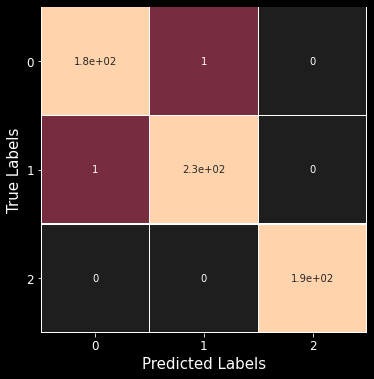

In [30]:
xgb_pred = clf.predict(x_test)
xgb_cm = confusion_matrix(y_test, xgb_pred)

plt.figure(figsize=(6, 6))
ax = sns.heatmap(xgb_cm, vmax=3, center=0, linewidths=.5,square=True, annot = True, cbar=False)
ax.xaxis.set_ticklabels(labels, fontsize = 12)
ax.yaxis.set_ticklabels(labels, fontsize = 12, rotation=0)
ax.set_xlabel('Predicted Labels',fontsize = 15)
ax.set_ylabel('True Labels',fontsize = 15)
plt.show()